# Other types of image model

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *

## Multi-label classification

### First model

In [3]:
from planet import f2

sz=256
metrics=[f2]
f_model = resnet34
PATH = "data/planet/"

In [4]:
label_csv = f'{PATH}train_v2.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

In [5]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
data = ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                            suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [6]:
learn = ConvLearner.pretrained(f_model, data, precompute=True, metrics=metrics)

In [6]:
lrf=learn.lr_find()

A Jupyter Widget

[ 0.      0.208   0.2846  0.8416]                             



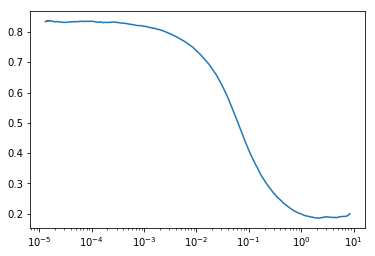

In [7]:
learn.sched.plot()

In [7]:
learn.fit(0.2, 2)

A Jupyter Widget

[ 0.      0.1275  0.1097  0.9065]                             
[ 1.      0.1214  0.1047  0.914 ]                             



In [8]:
learn.fit(0.2, 15)

A Jupyter Widget

[ 0.      0.1156  0.1029  0.9147]                             
[ 1.      0.1134  0.1021  0.916 ]                             
[ 2.      0.1157  0.1009  0.9157]                             
[ 3.      0.1094  0.1006  0.9166]                             
[ 4.      0.1092  0.0993  0.9186]                             
[ 5.      0.1081  0.0988  0.9187]                             
[ 6.      0.1048  0.0984  0.9181]                             
[ 7.      0.1026  0.0984  0.919 ]                             
[ 8.      0.1041  0.0978  0.9196]                             
[ 9.      0.102   0.0975  0.92  ]                             
[ 10.       0.1049   0.0975   0.9183]                         
[ 11.       0.1051   0.0989   0.915 ]                         
[ 12.       0.1042   0.0972   0.9187]                         
[ 13.       0.1006   0.0973   0.9196]                          
[ 14.       0.1027   0.0973   0.9196]                          



In [9]:
learn.precompute=False
learn.fit(0.2, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.      0.1171  0.1021  0.9155]                            
[ 1.      0.118   0.1019  0.9142]                            
[ 2.      0.1155  0.1008  0.9163]                            
[ 3.      0.1155  0.1018  0.9155]                            
[ 4.      0.115   0.1002  0.9168]                            
[ 5.      0.1123  0.0995  0.9174]                            
[ 6.      0.1106  0.0991  0.9178]                            



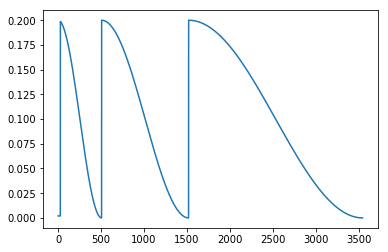

In [10]:
learn.sched.plot_lr()

In [12]:
learn.unfreeze()
lrs = np.array([0.02,0.07,0.2])
learn.precompute=False

In [13]:
learn.save('256_fc')

In [14]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.      0.102   0.0874  0.928 ]                            
[ 1.      0.0976  0.0835  0.931 ]                             
[ 2.      0.0902  0.0813  0.9336]                             
[ 3.      0.0957  0.0835  0.9311]                             
[ 4.      0.0907  0.081   0.933 ]                             
[ 5.      0.0881  0.0788  0.9355]                             
[ 6.      0.0835  0.0783  0.9358]                             



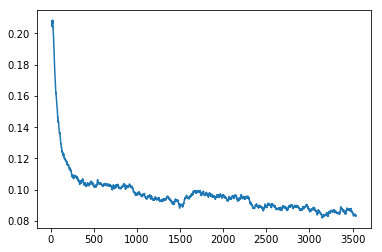

In [15]:
learn.sched.plot_loss()

### Increasing resolution during training

In [5]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

A Jupyter Widget

[ 0.      0.1979  0.217   0.8397]                             



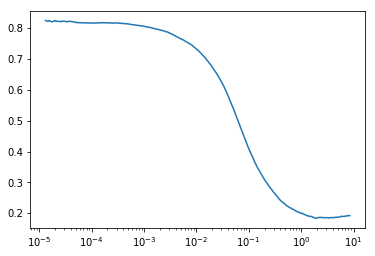

In [6]:
data = get_data(256)
learn = ConvLearner.pretrained(f_model, data, precompute=True, metrics=metrics)
lrf=learn.lr_find()
learn.sched.plot()

In [7]:
lr = 0.2
lrs = np.array([lr/10, lr/3, lr])
learn.precompute=False

In [8]:
def train_sz(sz):
    learn.set_data(get_data(sz))
    learn.freeze()
    learn.fit(lr, 3, cycle_len=1, cycle_mult=2)
    learn.unfreeze()
    learn.save(f'{sz}_fc')
    learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
    learn.save(f'{sz}')

In [9]:
for sz in (64,128,256):
    print(sz)
    train_sz(sz)
    print('----')

64


A Jupyter Widget

[ 0.      0.1443  0.1288  0.8879]                            
[ 1.      0.1398  0.1225  0.8952]                            
[ 2.      0.1349  0.1212  0.8964]                            
[ 3.      0.1379  0.1195  0.8986]                            
[ 4.      0.1336  0.1177  0.9007]                            
[ 5.      0.1297  0.1172  0.9002]                            
[ 6.      0.1322  0.1161  0.9018]                            



A Jupyter Widget

[ 0.      0.1194  0.101   0.9176]                            
[ 1.      0.1127  0.099   0.9167]                            
[ 2.      0.1066  0.0939  0.9224]                            
[ 3.      0.1086  0.0951  0.9227]                            
[ 4.      0.1061  0.0918  0.9258]                            
[ 5.      0.0983  0.0897  0.9261]                             
[ 6.      0.0955  0.0894  0.9259]                             

----
128
100%|██████████| 127/127 [00:09<00:00, 13.34it/s]


A Jupyter Widget

[ 0.      0.1005  0.0885  0.9262]                             
[ 1.      0.0984  0.0878  0.9267]                             
[ 2.      0.0956  0.087   0.9272]                             
[ 3.      0.099   0.0872  0.9273]                             
[ 4.      0.0933  0.0864  0.9289]                             
[ 5.      0.0937  0.0858  0.9286]                             
[ 6.      0.0925  0.086   0.9281]                             



A Jupyter Widget

[ 0.      0.0938  0.0826  0.9323]                             
[ 1.      0.0938  0.0836  0.9315]                             
[ 2.      0.0895  0.0812  0.9334]                             
[ 3.      0.0944  0.0845  0.9298]                             
[ 4.      0.089   0.0814  0.9332]                             
[ 5.      0.0841  0.0802  0.934 ]                             
[ 6.      0.0838  0.0797  0.9345]                             

----
256


A Jupyter Widget

[ 0.      0.0906  0.0851  0.9283]                             
[ 1.      0.0894  0.0838  0.9305]                             
[ 2.      0.0881  0.0834  0.931 ]                             
[ 3.      0.0906  0.0831  0.9313]                             
[ 4.      0.0898  0.0828  0.9314]                             
[ 5.      0.0889  0.0828  0.9304]                             
[ 6.      0.0877  0.0829  0.9307]                             



A Jupyter Widget

[ 0.      0.0878  0.0793  0.9351]                             
[ 1.      0.0896  0.0793  0.9354]                             
[ 2.      0.0852  0.0783  0.9356]                             
[ 3.      0.0862  0.0807  0.934 ]                             
[ 4.      0.0843  0.0784  0.9366]                             
[ 5.      0.0796  0.0778  0.9368]                             
[ 6.      0.0793  0.0776  0.9367]                             

----
